In [2]:
# ../../Pytorch Practice
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
import sys
sys.path.append("../../Pytorch Practice")
import d2lzh_pytorch as d2l

torch.set_default_tensor_type(torch.FloatTensor)

# 1. 数据读取

In [3]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
train_data, train_data.shape

(        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0        1          60       RL         65.0     8450   Pave   NaN      Reg   
 1        2          20       RL         80.0     9600   Pave   NaN      Reg   
 2        3          60       RL         68.0    11250   Pave   NaN      IR1   
 3        4          70       RL         60.0     9550   Pave   NaN      IR1   
 4        5          60       RL         84.0    14260   Pave   NaN      IR1   
 ...    ...         ...      ...          ...      ...    ...   ...      ...   
 1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
 1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
 1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
 1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
 1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   
 
      LandContour Utilities  ... PoolA

In [5]:
test_data, test_data.shape

(        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
 1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
 2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
 3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
 4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
 ...    ...         ...      ...          ...      ...    ...   ...      ...   
 1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
 1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
 1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
 1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
 1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   
 
      LandContour Utilities  ... Scree

In [6]:
# iloc[行, 列]
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 2. 预处理数据
- 对连续数值的特征（同一个）做标准化（standardization）
- 将离散数值转换成指示特征，一般会增加特征维数。举个例子，假设特征MSZoning⾥面有两个不同的离散值RL和RM，那么转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。 如果⼀个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean()) / (x.std()))
# 标准化，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

In [9]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

# 3. 训练模型
- 用线性回归来训练模型
- 用对数均方根误差评判模型
$$
\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(y_{i}\right)-\log \left(\hat{y}_{i}\right)\right)^{2}}
$$
- 使用Adam优化算法，相较于SGD，其对learning rate不那么敏感

In [11]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [12]:
def log_rmse(net, features, labels):
    # 不需要梯度？
    with torch.no_grad():
        # 将小于1的值设置成1，使得对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [13]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = Data.TensorDataset(train_features, train_labels)
    train_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [14]:
# 返回第i折数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # 整除
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        # 选验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 初始化训练集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 拼接
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [15]:
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        # *data表示将data的4个结果依次输入
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        # 只要最后依次的误差
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % 
             (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.210549, valid rmse 0.209023
fold 1, train rmse 0.204371, valid rmse 0.227561
fold 2, train rmse 0.202481, valid rmse 0.210030
fold 3, train rmse 0.208282, valid rmse 0.207501
fold 4, train rmse 0.201331, valid rmse 0.245818
5-fold validation: avg train rmse 0.205403, avg valid rmse 0.219987


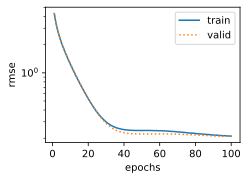

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % 
      (k, train_l, valid_l))

In [17]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.197984


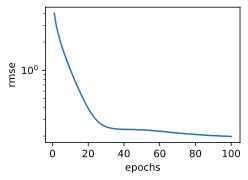

In [18]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

# 总结
1. 数据观察：特征，标签
2. 数据预处理：数值-标准化，非数值pd.get_dummies。
3. 划分训练集、测试集
4. 模型、评价函数确定
5. 训练：训练集、测试集、epochs、learning rate、drop、batch_size
6. K折算法预训练模型
7. 测试输入，生成结果